# Storm Identification in MRMS Data

In [14]:
import math
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import pandas as pd
import xarray as xr

import glob

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_closing, binary_dilation


from skimage.morphology import disk, remove_small_objects
from skimage.measure import regionprops

from skimage.segmentation import find_boundaries

import pickle
import pandas as pd
import datetime as dt
import geopandas as gpd
from shapely.geometry import MultiPoint

import skimage

## Defintions for Subsetting Convective Objects
These defintions are created by Alex Haberlie, so go bug him if you have questions. 

In [15]:
def create_slices(regions, cur_time, pix_len, conv_dbz, int_dbz):
    """Transforms the regionprops regions from get_qualifying_clusters
    into geopandas pickle files for easy access when running tracking.
    Pickle files are saved in a folder based on cur_time, and nothing
    is returned. 
    
    Parameters
    ----------
    regions: list
        List of regionprops that contains information for each contiguous
        reflectivity region defined in get_qualifying_clusters.
        
    cur_time: datetime
        The datetime for the current data
       
    pix_len: float
        Grid spacing of the input data. This is the distance between grid
        cells and is commonly communicated as "resolution".  Gridrad is 2,
        cheyenne simulations are 3.75.
        
    strat_dbz: int
        Threshold used to identify stratiform pixels 
       
    conv_dbz: int
        Threshold used to identify convective pixels 
        
    int_dbz: int
        Threshold used to identify intense pixels
    -------
    None
    """
    
    storm_list = []
    feature_list = ['area', 'convex_area', 'eccentricity', 'mean_intensity', 'max_intensity',
                'intensity_variance', 'major_axis_length', 'minor_axis_length',
                'solidity', 'convection_area', 'intense_area']

    for region in regions:

        features = calc_features(region, pixel_size=pix_len, 
                                 c_dbz=conv_dbz, 
                                 i_dbz=int_dbz)

        coords = region.coords

        polt = MultiPoint(region.coords).convex_hull

        xmin, xmax = np.min(coords[:, 1]), np.max(coords[:, 1])
        ymin, ymax = np.min(coords[:, 0]), np.max(coords[:, 0])

        features['xmin'] = xmin
        features['xmax'] = xmax
        features['ymin'] = ymin
        features['ymax'] = ymax
        features['coords'] = region.coords
        features['geometry'] = polt
        features['start_year'] = cur_time.year
        features['start_month'] = cur_time.month
        features['start_day'] = cur_time.day
        features['start_hour'] = cur_time.hour
        features['start_time'] = cur_time
            
        storm_list.append(features)
            
    #print(cur_time, len(regions))

    df = pd.DataFrame(storm_list)

    gdf = gpd.GeoDataFrame(df, geometry=df.geometry)
    
    return gdf
    

In [16]:
def calc_features(props, pixel_size, c_dbz, i_dbz):
    """Returns selected calculated attributes for a 
    given regionprops entry.
    
    Parameters
    ----------
    props: dict
        Attributes from a single regionprops entry. In other 
        words, attributes from a single cluster.
        
    pixel_size: float
        Grid spacing of the input data. This is the distance between grid
        cells and is commonly communicated as "resolution".  Gridrad is 2,
        cheyenne simulations are 3.75. Identical to pix_len, but changed
        to avoid confusion in create_slices.
    c_dbz: int
        Threshold used to identify convective pixels 
        
    i_dbz: int
        Threshold used to identify intense pixels
    Returns
    -------
    regions: dict
        A dictionary of the following selected attributes that are adjusted
        by pixel_size: 
        area, convex_area, eccentricity, mean_intensity, max_intensity,
        intensity_variance, major_axis_length, minor_axis_length,
        solidity, stratiform_area, convection_area, intense_area
    """    
    feature_list = ['area', 'convex_area', 'eccentricity', 'mean_intensity', 'max_intensity',
                'intensity_variance', 'major_axis_length', 'minor_axis_length',
                'solidity', 'convection_area', 'intense_area' ]    
        
    area = props.area * (pixel_size*pixel_size)
    convex_area = props.convex_area * (pixel_size*pixel_size)

    convection_area = np.sum(props.intensity_image >= c_dbz) * (pixel_size*pixel_size)
    intense_area = np.sum(props.intensity_image >= i_dbz) * (pixel_size*pixel_size)

    eccentricity = props.eccentricity
    
    mean_intensity = props.mean_intensity
    max_intensity = props.max_intensity
    
    major_axis_length = props.major_axis_length * pixel_size
    minor_axis_length = props.minor_axis_length * pixel_size
    
    ind = np.where(props.intensity_image>0)
    intensity_variance = np.var(props.intensity_image[ind]) 
    
    arr = np.array([area, convex_area, eccentricity, mean_intensity, max_intensity,
                    intensity_variance, major_axis_length, minor_axis_length,
                    props.solidity, convection_area, intense_area])

    feature_dict = dict((key, value) for (key, value) in zip(feature_list, arr))
        
    return feature_dict

## Creating Convective Objects Information

A note: resist the sudden and overwhelming urge to correct the region boxes into an upright and correct looking United States. It will only make things worse in the future, I promise. However, if you really want to fix it the code to do so is there commentted out. 

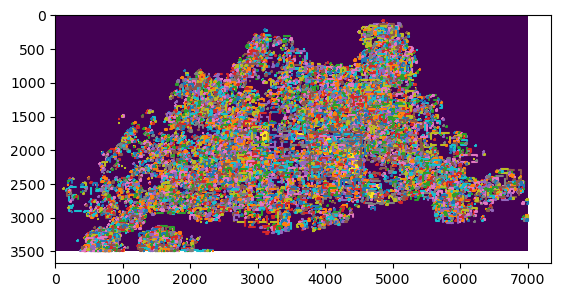

In [17]:
#obtain all the folders for each storm event.
storm_dates = glob.glob('/gpfs/fs1/home/ac.jcorner/NIU/Masters_Thesis/metplus/metplus_input/MODE_data/*')
storm_dates.sort()
slices = []

#interate through each directory.
for dates_dir in storm_dates:
    
    #open and grab simple data from each file.
    rain_data = glob.glob(f'{dates_dir}/mrms*')
    data = xr.open_dataset(rain_data[0])
    mrms = data.mrms_lcref
    dtime = dt.datetime.strptime(rain_data[0][-16:-4], '%Y%m%d%H%M%S')
    conv_regions = mrms.values >= 20

    #use label to find each contiuos object of a threshold value (20 dBz in this case). Remove small objects as well.
    labels = label(conv_regions, connectivity=2)
    labels = remove_small_objects(labels, min_size=25)
    #labels = rotate(labels, angle=180, order =0)
    #labels = np.flip(labels, 1)
    
    #create the information for each object.
    regions = regionprops(labels, intensity_image=mrms.values)

    plt.imshow(labels, vmin=0, vmax=40)

    #creating the bounding boxes for each object.
    for region in regions:

        bbox = region.bbox

        ymin = bbox[0]
        ymax = bbox[2]

        xmin = bbox[1]
        xmax = bbox[3]

        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], '--')
        
    #use Alex's defintion to finish creating all the iformation and append it.
    slices_ = create_slices(regions, pd.to_datetime(dtime), 1, 20, 40)
    slices.append(slices_)

slices = pd.concat(slices, ignore_index=True)


In [21]:
uniq_id = []

#create a unique id to each object for easier use down the road.
for i in range(slices.shape[0]):
    uniq_id.append(f'mrms{slices.start_year[i]}{str(slices.start_month[i]).zfill(2)}{str(slices.start_day[i]).zfill(2)}r{i}')

#inset the values into the dataframe.    
slices.insert(loc=0, column="uniq_id", value=uniq_id)

#save the dataframe as a pickle.
pickle.dump(slices, open('storm_data/mrms/mrms_storm_ids3.pkl', 'wb'))


slices

,uniq_id,area,convex_area,eccentricity,mean_intensity,max_intensity,intensity_variance,major_axis_length,minor_axis_length,solidity,...,xmax,ymin,ymax,coords,geometry,start_year,start_month,start_day,start_hour,start_time
0,mrms20200603r0,30.0,33.0,0.964007,22.183333,25.0,2.558056,12.236631,3.253437,0.909091,...,5058,247,254,"[[247, 5050], [247, 5051], [248, 5049], [248, ...","POLYGON ((248.000 5049.000, 247.000 5050.000, ...",2020,6,3,0,2020-06-03
1,mrms20200603r1,39.0,45.0,0.891489,25.487179,34.0,21.160092,11.257467,5.100104,0.866667,...,5048,249,257,"[[249, 5041], [249, 5042], [250, 5040], [250, ...","POLYGON ((251.000 5039.000, 249.000 5041.000, ...",2020,6,3,0,2020-06-03
2,mrms20200603r2,74.0,92.0,0.804842,26.067568,35.0,26.164354,13.180803,7.822667,0.804348,...,5036,253,264,"[[253, 5023], [254, 5024], [254, 5029], [254, ...","POLYGON ((253.000 5023.000, 254.000 5030.000, ...",2020,6,3,0,2020-06-03
3,mrms20200603r3,26.0,27.0,0.902015,22.326923,24.0,1.268121,8.749284,3.777115,0.962963,...,4907,259,262,"[[259, 4900], [259, 4901], [259, 4902], [259, ...","POLYGON ((259.000 4900.000, 259.000 4903.000, ...",2020,6,3,0,2020-06-03
4,mrms20200603r4,182.0,288.0,0.831924,22.423077,27.5,4.788039,25.107762,13.932054,0.631944,...,4895,279,293,"[[279, 4875], [279, 4876], [280, 4875], [280, ...","POLYGON ((287.000 4870.000, 279.000 4875.000, ...",2020,6,3,0,2020-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16068,mrms20200811r16068,175.0,218.0,0.984916,28.271429,42.5,26.750612,38.722480,6.700163,0.802752,...,4933,2801,2807,"[[2801, 4911], [2801, 4912], [2801, 4913], [28...","POLYGON ((2805.000 4898.000, 2803.000 4899.000...",2020,8,11,0,2020-08-11
16069,mrms20200811r16069,28.0,31.0,0.873680,24.892857,26.5,1.131378,8.619369,4.193331,0.903226,...,858,3146,3150,"[[3146, 855], [3146, 856], [3147, 853], [3147,...","POLYGON ((3149.000 850.000, 3148.000 851.000, ...",2020,8,11,0,2020-08-11
16070,mrms20200811r16070,53.0,89.0,0.981619,24.924528,31.0,9.107512,22.368716,4.269086,0.595506,...,797,3432,3436,"[[3432, 780], [3432, 781], [3432, 782], [3432,...","POLYGON ((3434.000 775.000, 3432.000 780.000, ...",2020,8,11,0,2020-08-11
16071,mrms20200811r16071,54.0,88.0,0.985333,22.259259,25.5,2.164266,22.920510,3.911226,0.613636,...,810,3491,3496,"[[3491, 800], [3492, 796], [3492, 797], [3492,...","POLYGON ((3494.000 789.000, 3493.000 792.000, ...",2020,8,11,0,2020-08-11
